In [1]:
import os
import requests
import io
import sys

from pyteomics import mzxml  # Library used to open mzxml format files (spectra format)

from spectrum import Spectrum

import numpy as np
import pandas as pd

from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn_extra.cluster import KMedoids
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.preprocessing import MinMaxScaler

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

## Extract data

In [2]:
download_url = 'https://getfile.dokpub.com/yandex/get/https://yadi.sk/d/hsVX9julguUOPQ'

# Getting data from the cloud
response = requests.get(download_url, stream=True)
if response.status_code == 200:
    file_stream = io.BytesIO(response.content)
    ms_data = mzxml.read(file_stream)
    spectra = list(ms_data)  # List containing all spectra of the chromatogram
else:
    print(f'Failed to download file. Status code: {response.status_code}')
    sys.exit()

print(f'Number of mass spectra: {len(spectra)}')
gcms = []  # gas chromatography–mass spectrometry

for spec in spectra:

    mz = spec.pop('m/z array')
    mz = mz[::-1]  # Array of values mz; change the order of elements in the array from decreasing to increasing

    intensities = spec.pop('intensity array')
    intensities = intensities[::-1]  # Array of intensities values; change the order of elements in the array
    
    substance_name = None
    
    metadata = {
        'id': spec['id'],
        'retention time': round(spec['retentionTime'], 2),  # Retention time, rounded to hundredths
        'total ion current': intensities.sum(),
        'array length': spec['peaksCount'],
        'base peak mz': spec['basePeakMz']
    }
    
    spectrum = Spectrum(mz, intensities, substance_name, **metadata)  # Create a Spectrum object
    # spectrum.normalize()  # Min-max normalization
    
    gcms.append(spectrum)

Number of mass spectra: 7617


## Chromatogram

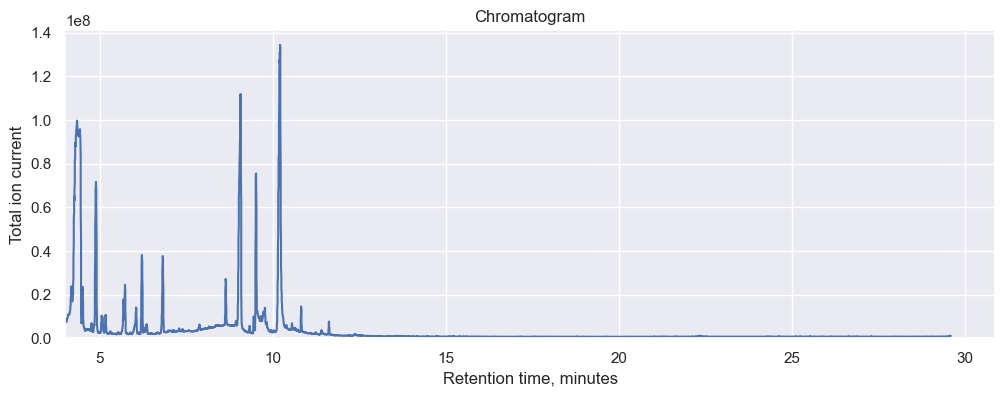

In [3]:
# Arrays of retention times and total ion currents
retention_times = np.array([spectrum.metadata['retention time'] for spectrum in gcms])
tot_ion_currents = np.array([spectrum.metadata['total ion current'] for spectrum in gcms])

# Chromatogram image
plt.figure(figsize=(12,4))
plt.plot(retention_times, tot_ion_currents)
plt.xlim(left=retention_times.min())
plt.ylim(bottom=0)
plt.xlabel('Retention time, minutes')
plt.ylabel('Total ion current')
plt.title(f'Chromatogram')
plt.show()

## Heat map

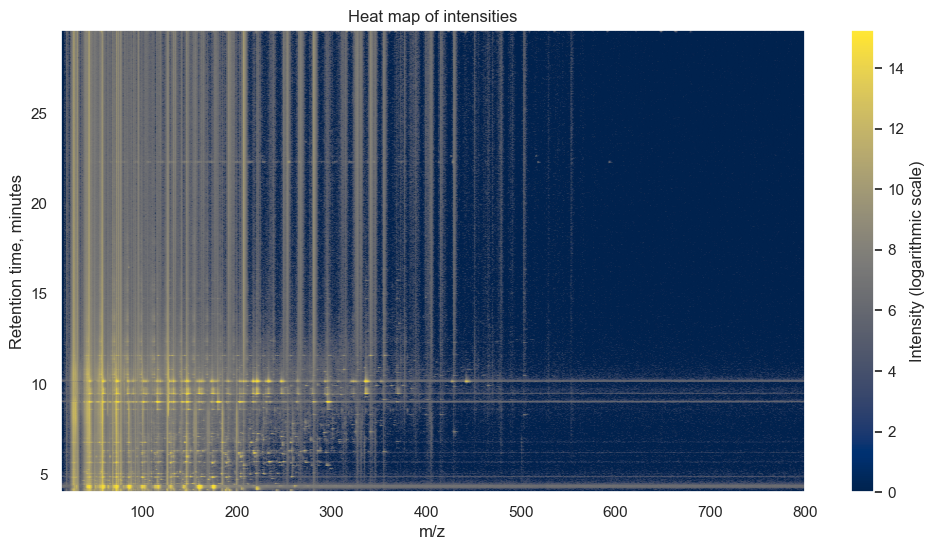

In [4]:
# Heat map
mz = gcms[0].mz  # Extract an arbitrary array m/z
intensities = np.array([spectrum.intensities for spectrum in gcms])  # Extract the intensity arrays
log_intensities = np.log1p(intensities)  # Go to logarithmic scale

Mz, RetentionTimes = np.meshgrid(mz, retention_times)  # Create a grid

plt.figure(figsize=(12, 6))
heatmap = plt.pcolormesh(Mz, RetentionTimes, log_intensities, cmap='cividis', shading='gouraud')
plt.colorbar(heatmap, label='Intensity (logarithmic scale)')
plt.xlabel('m/z')
plt.ylabel('Retention time, minutes')
plt.title(f'Heat map of intensities')
plt.show()

## Elbow method

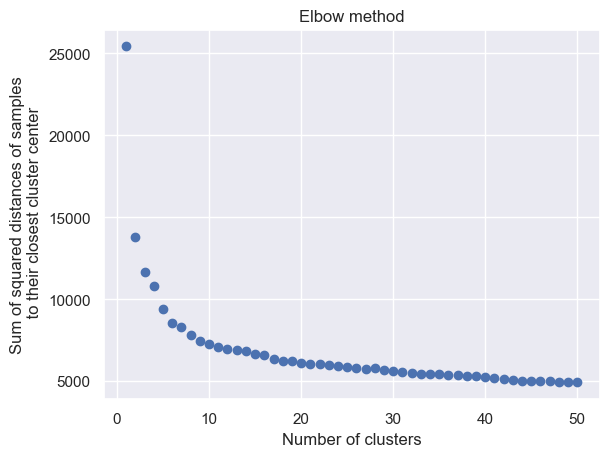

In [5]:
sse = []  # List for storing sum of squares values of distances
n_clusters_max = 50  # Maximum number of clusters

# Data normalization
scaler = MinMaxScaler()
X = intensities
X_normalized = scaler.fit_transform(X)

# Try different numbers of clusters and calculate sum of squared distances of samples to their closest cluster center
n_clusters_range = range(1, n_clusters_max+1)
for k in n_clusters_range:
    kmeans = KMeans(n_clusters=k, random_state=0)
    kmeans.fit(X_normalized)
    sse.append(kmeans.inertia_)

# Elbow method graph
plt.scatter(n_clusters_range, sse, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Sum of squared distances of samples\n to their closest cluster center')
plt.title('Elbow method')
plt.show()

## Clustering algorithms

In [6]:
def compute_metrics(X, cluster_labels):  # Function for calculating quality metrics
    silhouette = silhouette_score(X, cluster_labels)
    db_index = davies_bouldin_score(X, cluster_labels)
    ch_index = calinski_harabasz_score(X, cluster_labels)
    return silhouette, db_index, ch_index

def run_algorithm(algorithm, X):  # Function to run the algorithm and calculate quality metrics
    cluster_labels = algorithm.fit_predict(X)
    return compute_metrics(X, cluster_labels)

In [7]:
n_clusters = 30  # Number of clusters

# Initialization of algorithms
kmeans = KMeans(n_clusters=n_clusters, random_state=0)
kmedoids = KMedoids(n_clusters=n_clusters)
agglomerative = AgglomerativeClustering(n_clusters=n_clusters)
gmm = GaussianMixture(n_components=n_clusters, random_state=0)

# Execution of algorithms and calculation of quality metrics
algorithms = [kmeans, kmedoids, agglomerative, gmm]
algorithm_names = ['K-Means', 'K-Medoids', 'Agglomerative', 'GMM']
metrics = []

for algorithm, name in zip(algorithms, algorithm_names):
    silhouette, db_index, ch_index = run_algorithm(algorithm, X_normalized)
    metrics.append({'Algorithm': name, 
                    'Silhouette Score': silhouette, 
                    'Davies-Bouldin Index': db_index, 
                    'Calinski-Harabasz Index': ch_index})

metrics_df = pd.DataFrame(metrics).set_index('Algorithm')  # Create a DataFrame with metrics

print("Comparison of clustering quality metrics:")
metrics_df.sort_values('Silhouette Score', ascending=False)

Comparison of clustering quality metrics:


,Silhouette Score,Davies-Bouldin Index,Calinski-Harabasz Index
Algorithm,,,
Agglomerative,0.066183,1.749788,928.890903
K-Means,0.038286,2.319761,926.484945
GMM,0.038286,2.319761,926.484945
K-Medoids,-0.080238,5.214459,69.343807


## Agglomerative algorithm

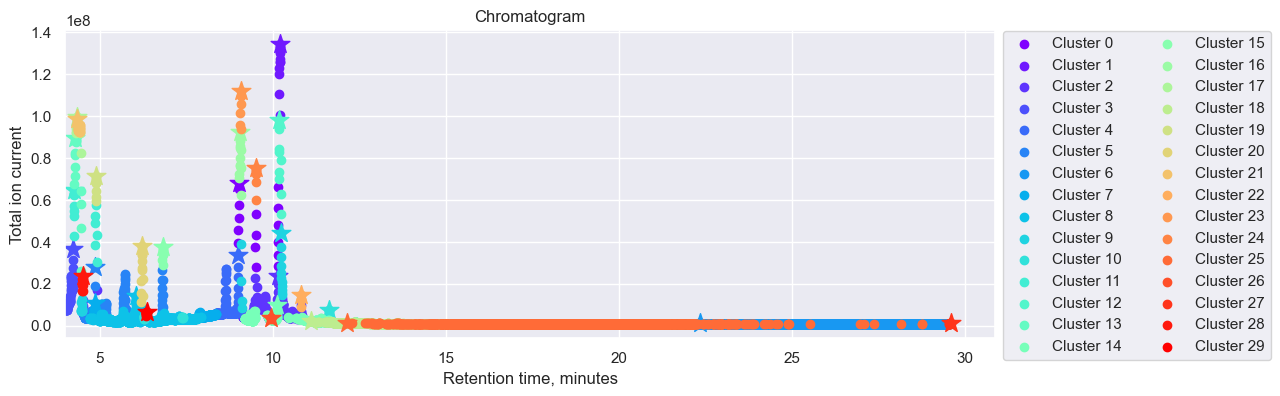

In [8]:
cluster_labels = agglomerative.fit_predict(X_normalized)  # Algorithm with the best result

# # Add a cluster label to spectra in gcms
# for spectrum, cluster_label in zip(gcms, cluster_labels):
#     spectrum.metadata['cluster label'] = cluster_label

plt.figure(figsize=(12, 4))
colors = plt.cm.rainbow(np.linspace(0, 1, len(set(cluster_labels))))  # Colors of clusters

for cluster_label, color in zip(set(cluster_labels), colors):
    # Select the points of the current cluster
    x = [retention_times[i] for i in range(len(retention_times)) if cluster_labels[i] == cluster_label]
    y = [tot_ion_currents[i] for i in range(len(tot_ion_currents)) if cluster_labels[i] == cluster_label]

    plt.scatter(x, y, label=f'Cluster {cluster_label}', color=color)  # Draw the points of the current cluster
    max_index = np.argmax(y)  # Search for the index of the point with the maximum value of tot_ion_current
    # Draw the point with the maximum value of tot_ion_current
    plt.scatter(x[max_index], y[max_index], color=color, marker='*', s=200)

plt.xlim(left=retention_times.min())
plt.xlabel('Retention time, minutes')
plt.ylabel('Total ion current')
plt.title(f'Chromatogram')
plt.legend(bbox_to_anchor=(1.0, 1.023), loc='upper left', ncol=2)
plt.show()

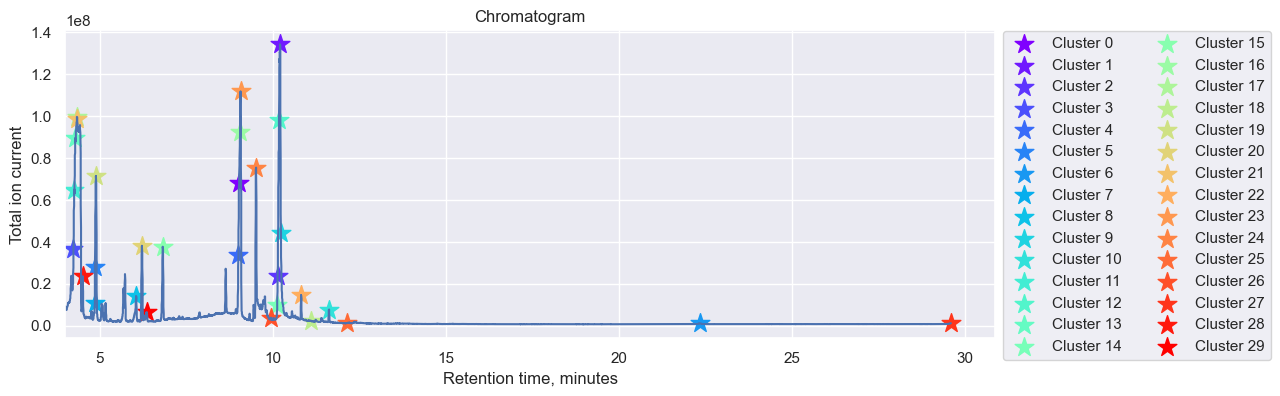

In [9]:
plt.figure(figsize=(12, 4))
plt.plot(retention_times, tot_ion_currents)

for cluster_label, color in zip(set(cluster_labels), colors):
    # Select the points of the current cluster
    x = [retention_times[i] for i in range(len(retention_times)) if cluster_labels[i] == cluster_label]
    y = [tot_ion_currents[i] for i in range(len(tot_ion_currents)) if cluster_labels[i] == cluster_label]
    
    max_index = np.argmax(y)  # Search for the index of the point with the maximum value of tot_ion_current
    # Draw the point with the maximum value of tot_ion_current
    plt.scatter(x[max_index], y[max_index], color=color, marker='*', s=200, label=f'Cluster {cluster_label}')

plt.xlim(left=retention_times.min())
plt.xlabel('Retention time, minutes')
plt.ylabel('Total ion current')
plt.title(f'Chromatogram')
plt.legend(bbox_to_anchor=(1.0, 1.023), loc='upper left', ncol=2)
plt.show()